# A/B-тестирование

**Цели**: оценка корректности проведения АВ теста, анализ результатов теста

### Описание данных

`ab_project_marketing_events.csv` — календарь маркетинговых событий на 2020 год.

Структура файла:

- `name` — название маркетингового события;
- `regions` — регионы, в которых будет проводиться рекламная кампания;
- `start_dt` — дата начала кампании;
- `finish_dt` — дата завершения кампании.

`final_ab_new_users.csv` — пользователи, зарегистрировавшиеся с 7 по 21 декабря 2020 года.

Структура файла:

- `user_id` — идентификатор пользователя;
- `first_date` — дата регистрации;
- `region` — регион пользователя;
- `device` — устройство, с которого происходила регистрация.

`final_ab_events.csv` — действия новых пользователей в период с 7 декабря 2020 по 4 января 2021 года.

Структура файла:

- `user_id` — идентификатор пользователя;
- `event_dt` — дата и время покупки;
- `event_name` — тип события;
- `details` — дополнительные данные о событии. Например, для покупок, `purchase,` в этом поле хранится стоимость покупки в долларах.

`final_ab_participants.csv` — таблица участников тестов.

Структура файла:

- `user_id` — идентификатор пользователя;
- `ab_test` — название теста;
- `group` — группа пользователя.

### Техническое задание

- Название теста: `recommender_system_test`;
- группы: А — контрольная, B — новая платёжная воронка;
- дата запуска: 2020-12-07;
- дата остановки набора новых пользователей: 2020-12-21;
- дата остановки: 2021-01-04;
- аудитория: 15% новых пользователей из региона EU;
- назначение теста: тестирование изменений, связанных с внедрением улучшенной рекомендательной системы;
- ожидаемое количество участников теста: 6000.
- ожидаемый эффект: за 14 дней с момента регистрации пользователи покажут улучшение каждой метрики не менее, чем на 10%:
    - конверсии в просмотр карточек товаров — событие `product_page`,
    - просмотры корзины — `product_cart`,
    - покупки — `purchase`.

# 1. Загрузка данных и библиотек

In [224]:
import pandas as pd
import numpy as np
from scipy import stats as st
import math as mth
import plotly.graph_objects as go

In [225]:
marketing = pd.read_csv("C:/Users/kast1/Desktop/практикум/выпускной/ab_project_marketing_events.csv")

marketing

,name,regions,start_dt,finish_dt
0,Christmas&New Year Promo,"EU, N.America",2020-12-25,2021-01-03
1,St. Valentine's Day Giveaway,"EU, CIS, APAC, N.America",2020-02-14,2020-02-16
2,St. Patric's Day Promo,"EU, N.America",2020-03-17,2020-03-19
3,Easter Promo,"EU, CIS, APAC, N.America",2020-04-12,2020-04-19
4,4th of July Promo,N.America,2020-07-04,2020-07-11
5,Black Friday Ads Campaign,"EU, CIS, APAC, N.America",2020-11-26,2020-12-01
6,Chinese New Year Promo,APAC,2020-01-25,2020-02-07
7,Labor day (May 1st) Ads Campaign,"EU, CIS, APAC",2020-05-01,2020-05-03
8,International Women's Day Promo,"EU, CIS, APAC",2020-03-08,2020-03-10
9,Victory Day CIS (May 9th) Event,CIS,2020-05-09,2020-05-11


In [226]:
events = pd.read_csv("C:/Users/kast1/Desktop/практикум/выпускной/final_ab_events.csv")

events.head()

,user_id,event_dt,event_name,details
0,E1BDDCE0DAFA2679,2020-12-07 20:22:03,purchase,99.99
1,7B6452F081F49504,2020-12-07 09:22:53,purchase,9.99
2,9CD9F34546DF254C,2020-12-07 12:59:29,purchase,4.99
3,96F27A054B191457,2020-12-07 04:02:40,purchase,4.99
4,1FD7660FDF94CA1F,2020-12-07 10:15:09,purchase,4.99


In [227]:
new_users = pd.read_csv("C:/Users/kast1/Desktop/практикум/выпускной/final_ab_new_users.csv")

new_users.head()

,user_id,first_date,region,device
0,D72A72121175D8BE,2020-12-07,EU,PC
1,F1C668619DFE6E65,2020-12-07,N.America,Android
2,2E1BF1D4C37EA01F,2020-12-07,EU,PC
3,50734A22C0C63768,2020-12-07,EU,iPhone
4,E1BDDCE0DAFA2679,2020-12-07,N.America,iPhone


In [228]:
participants = pd.read_csv("C:/Users/kast1/Desktop/практикум/выпускной/final_ab_participants.csv")

participants.head()

,user_id,group,ab_test
0,D1ABA3E2887B6A73,A,recommender_system_test
1,A7A3664BD6242119,A,recommender_system_test
2,DABC14FDDFADD29E,A,recommender_system_test
3,04988C5DF189632E,A,recommender_system_test
4,482F14783456D21B,B,recommender_system_test


# 2. Предобработка данных

In [229]:
marketing.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14 entries, 0 to 13
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   name       14 non-null     object
 1   regions    14 non-null     object
 2   start_dt   14 non-null     object
 3   finish_dt  14 non-null     object
dtypes: object(4)
memory usage: 288.0+ bytes


In [230]:
marketing['start_dt'] = pd.to_datetime(marketing['start_dt'], format='%Y.%m.%d')
marketing['finish_dt'] = pd.to_datetime(marketing['finish_dt'], format='%Y.%m.%d')

In [231]:
marketing.duplicated().sum()

0

In [232]:
events.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 440317 entries, 0 to 440316
Data columns (total 4 columns):
 #   Column      Non-Null Count   Dtype  
---  ------      --------------   -----  
 0   user_id     440317 non-null  object 
 1   event_dt    440317 non-null  object 
 2   event_name  440317 non-null  object 
 3   details     62740 non-null   float64
dtypes: float64(1), object(3)
memory usage: 8.4+ MB


In [233]:
events['event_dt'] = pd.to_datetime(events['event_dt'], format='%Y.%m.%d')

In [234]:
events.duplicated().sum()

0

In [235]:
new_users.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 61733 entries, 0 to 61732
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   user_id     61733 non-null  object
 1   first_date  61733 non-null  object
 2   region      61733 non-null  object
 3   device      61733 non-null  object
dtypes: object(4)
memory usage: 964.6+ KB


In [236]:
new_users['first_date'] = pd.to_datetime(new_users['first_date'], format='%Y.%m.%d')

In [237]:
new_users.duplicated().sum()

0

In [238]:
participants.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18268 entries, 0 to 18267
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   user_id  18268 non-null  object
 1   group    18268 non-null  object
 2   ab_test  18268 non-null  object
dtypes: object(3)
memory usage: 214.1+ KB


In [239]:
participants.duplicated().sum()

0

# Вывод

Дубликатов в данных не обнаружено, даты приведены к нужному типу данных. Пропуски есть только в таблице event в столбце с  дополнительными данными о событии. Так как они не обязательны и для всех строк применимы, присуствуют пропуски.

# 3. Исследовательский анализ данных

*Проверим данные на соответствие условиям теста*

### 3.1 Проверка на участие в тесте recommender_system_test

In [240]:
participants['ab_test'].value_counts()

interface_eu_test          11567
recommender_system_test     6701
Name: ab_test, dtype: int64

In [241]:
# удалим пользователей, которые учавствовали в 2х тестах
participants.drop_duplicates('user_id', inplace=True, keep=False) 

Так как нас интересует только тест recommender_system_test, удалим строки с interface_eu_test

In [242]:
participants = participants.query('ab_test == "recommender_system_test"')
participants

,user_id,group,ab_test
0,D1ABA3E2887B6A73,A,recommender_system_test
1,A7A3664BD6242119,A,recommender_system_test
4,482F14783456D21B,B,recommender_system_test
5,4FF2998A348C484F,A,recommender_system_test
6,7473E0943673C09E,A,recommender_system_test
...,...,...,...
6696,053FB26D6D49EDDC,A,recommender_system_test
6697,9D263B8EF15CF188,B,recommender_system_test
6698,F2FBBA33F37DEC46,A,recommender_system_test
6699,29C92313A98B1176,B,recommender_system_test


In [243]:
# пользователи, которые участвовали только в одном тесте
np.setxor1d(
    participants.query("ab_test == 'recommender_system_test'")["user_id"],
    participants.query("ab_test == 'interface_eu_test'")["user_id"]
)

array(['000ABE35EE11412F', '0010A1C096941592', '001C05E87D336C59', ...,
       'FFB3F647898BA928', 'FFC2C5F898D1245B', 'FFE858A7845F005E'],
      dtype=object)

In [244]:
participants.duplicated().sum()

0

In [245]:
# проверка на правильность попадания пользователей только в одну группу.
check = participants.groupby('user_id')['group'].nunique().reset_index()
check

,user_id,group
0,000ABE35EE11412F,1
1,0010A1C096941592,1
2,001C05E87D336C59,1
3,003DF44D7589BBD4,1
4,00505E15A9D81546,1
...,...,...
5094,FF8CF7057415EB29,1
5095,FFAE9489C76F352B,1
5096,FFB3F647898BA928,1
5097,FFC2C5F898D1245B,1


In [246]:
check['group'].value_counts()

1    5099
Name: group, dtype: int64

In [247]:
participants['group'].value_counts()

A    2903
B    2196
Name: group, dtype: int64

разница в объёме групп может говорить о неполадках в инструменте разбиения клиентов на группы

### 3.2 Проверка на соответствие датам проведения 

In [248]:
new_users['first_date'].min()

Timestamp('2020-12-07 00:00:00')

In [249]:
new_users['first_date'].max()

Timestamp('2020-12-23 00:00:00')

По условиям задания набор новых пользователей останавливается 2020-12-21, т.е удалим данные за 22-е и 23-е числа

In [250]:
new_users = new_users.query('first_date <= "2020-12-21"')
new_users

,user_id,first_date,region,device
0,D72A72121175D8BE,2020-12-07,EU,PC
1,F1C668619DFE6E65,2020-12-07,N.America,Android
2,2E1BF1D4C37EA01F,2020-12-07,EU,PC
3,50734A22C0C63768,2020-12-07,EU,iPhone
4,E1BDDCE0DAFA2679,2020-12-07,N.America,iPhone
...,...,...,...,...
61728,1DB53B933257165D,2020-12-20,EU,Android
61729,538643EB4527ED03,2020-12-20,EU,Mac
61730,7ADEE837D5D8CBBD,2020-12-20,EU,PC
61731,1C7D23927835213F,2020-12-20,EU,iPhone


### 3.3 Проверка на регион проведения

In [251]:
# по условиям теста, должно быть 15% новых пользователей из региона EU;
new_users['region'].value_counts()

EU           42340
N.America     8347
CIS           2900
APAC          2883
Name: region, dtype: int64

In [252]:
# удалим остальные регионы
new_users = new_users.query('region == "EU"')

In [289]:
# объеденим таблицы, чтобы было видно какие действия совершали участники теста
df = participants.merge(events, how='left', on='user_id').merge(new_users, how='left', on='user_id')
df

,user_id,group,ab_test,event_dt,event_name,details,first_date,region,device
0,D1ABA3E2887B6A73,A,recommender_system_test,2020-12-07 14:43:27,purchase,99.99,2020-12-07,EU,PC
1,D1ABA3E2887B6A73,A,recommender_system_test,2020-12-25 00:04:56,purchase,4.99,2020-12-07,EU,PC
2,D1ABA3E2887B6A73,A,recommender_system_test,2020-12-07 14:43:29,product_cart,NaN,2020-12-07,EU,PC
3,D1ABA3E2887B6A73,A,recommender_system_test,2020-12-25 00:04:57,product_cart,NaN,2020-12-07,EU,PC
4,D1ABA3E2887B6A73,A,recommender_system_test,2020-12-07 14:43:27,product_page,NaN,2020-12-07,EU,PC
...,...,...,...,...,...,...,...,...,...
21110,6715343AFBA285AE,B,recommender_system_test,2020-12-07 10:12:15,login,NaN,NaT,NaN,NaN
21111,6715343AFBA285AE,B,recommender_system_test,2020-12-08 22:51:16,login,NaN,NaT,NaN,NaN
21112,6715343AFBA285AE,B,recommender_system_test,2020-12-09 02:28:03,login,NaN,NaT,NaN,NaN
21113,6715343AFBA285AE,B,recommender_system_test,2020-12-10 22:55:14,login,NaN,NaT,NaN,NaN


### 3.4 Проверка на активность в течении 14 дней

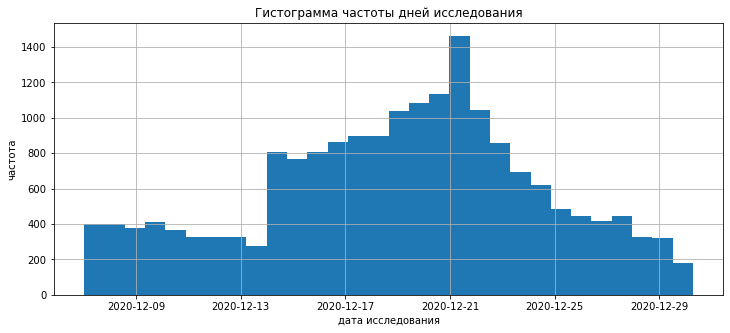

In [290]:
# построим гистограмму частоты дней исследования 
import matplotlib.pyplot as plt
df['event_dt'].hist(figsize=(12,5), bins=30)
plt.title('Гистограмма частоты дней исследования')
plt.xlabel('дата исследования')
plt.ylabel('частота');

Наибольшая активность у пользоватей была перед Католическим Рождеством и постепенно снижалась к концу теста. Кроме того нет полных данных до даты окончания теста 4.01, выгружены только до 30.12, поэтому начиная с 16.12 нет полных данных (14 дней) об активности клиентов, что является условием в техническом задании. Удалим события после 16.12.

In [291]:
df = df.query('first_date <= "2020-12-15"')
df

,user_id,group,ab_test,event_dt,event_name,details,first_date,region,device
0,D1ABA3E2887B6A73,A,recommender_system_test,2020-12-07 14:43:27,purchase,99.99,2020-12-07,EU,PC
1,D1ABA3E2887B6A73,A,recommender_system_test,2020-12-25 00:04:56,purchase,4.99,2020-12-07,EU,PC
2,D1ABA3E2887B6A73,A,recommender_system_test,2020-12-07 14:43:29,product_cart,NaN,2020-12-07,EU,PC
3,D1ABA3E2887B6A73,A,recommender_system_test,2020-12-25 00:04:57,product_cart,NaN,2020-12-07,EU,PC
4,D1ABA3E2887B6A73,A,recommender_system_test,2020-12-07 14:43:27,product_page,NaN,2020-12-07,EU,PC
...,...,...,...,...,...,...,...,...,...
19676,80712ED4EA1B52A5,A,recommender_system_test,2020-12-15 20:10:06,product_page,NaN,2020-12-14,EU,Android
19677,80712ED4EA1B52A5,A,recommender_system_test,2020-12-20 20:01:34,product_page,NaN,2020-12-14,EU,Android
19678,80712ED4EA1B52A5,A,recommender_system_test,2020-12-14 05:48:50,login,NaN,2020-12-14,EU,Android
19679,80712ED4EA1B52A5,A,recommender_system_test,2020-12-15 20:10:03,login,NaN,2020-12-14,EU,Android


In [292]:
df['event_name'].unique()

array(['purchase', 'product_cart', 'product_page', 'login', nan],
      dtype=object)

Всего 4 события: страница входа, страница товара, корзина, покупка, и есть пропуски, значит какие-то пользователи были неактивны, по условиям теста за 14 дней с момента регистрации пользователи покажут улучшение каждой метрики не менее, чем на 10%, т.е. они должны быть активны, удалим этих пользователей.

In [293]:
df = df[df['event_name'].notna()]
df

,user_id,group,ab_test,event_dt,event_name,details,first_date,region,device
0,D1ABA3E2887B6A73,A,recommender_system_test,2020-12-07 14:43:27,purchase,99.99,2020-12-07,EU,PC
1,D1ABA3E2887B6A73,A,recommender_system_test,2020-12-25 00:04:56,purchase,4.99,2020-12-07,EU,PC
2,D1ABA3E2887B6A73,A,recommender_system_test,2020-12-07 14:43:29,product_cart,NaN,2020-12-07,EU,PC
3,D1ABA3E2887B6A73,A,recommender_system_test,2020-12-25 00:04:57,product_cart,NaN,2020-12-07,EU,PC
4,D1ABA3E2887B6A73,A,recommender_system_test,2020-12-07 14:43:27,product_page,NaN,2020-12-07,EU,PC
...,...,...,...,...,...,...,...,...,...
19676,80712ED4EA1B52A5,A,recommender_system_test,2020-12-15 20:10:06,product_page,NaN,2020-12-14,EU,Android
19677,80712ED4EA1B52A5,A,recommender_system_test,2020-12-20 20:01:34,product_page,NaN,2020-12-14,EU,Android
19678,80712ED4EA1B52A5,A,recommender_system_test,2020-12-14 05:48:50,login,NaN,2020-12-14,EU,Android
19679,80712ED4EA1B52A5,A,recommender_system_test,2020-12-15 20:10:03,login,NaN,2020-12-14,EU,Android


In [295]:
# в среднем пользователь совершил 6.8 действий, максимально 28
p = df.groupby('user_id')['event_name'].count().reset_index()
p['event_name'].mean()

6.826371826371826

In [296]:
p['event_name'].min()

1

In [297]:
p['event_name'].max()

28

In [298]:
# общее число участников
df['user_id'].nunique()

1221

# Вывод

- Всего 4 события: страница входа, страница товара, корзина, покупка.
- в среднем пользователь совершил 7 действий, максимально 28, минимально 1.

Были удалены пользователи, несоответствующие условиям технического задания. Общее число участников 1221, при ожидаемых 6000. Кроме того, тест проводился во время маректинговой акции Christmas&New Year Promo, что нарушает правило проведения АВ тестов, т.к. можно получить недостоверные результаты, на которые повлияла именно акция.

## 3. Простая воронка событий

In [262]:
# количество переходов по страницам
df['event_name'].value_counts().reset_index()

,index,event_name
0,login,3848
1,product_page,2315
2,product_cart,1135
3,purchase,1037


In [263]:
# количество уникальных переходов по страницам
each_event = df.groupby('event_name')['user_id'].nunique().reset_index().sort_values(by='user_id', ascending=False)
each_event

,event_name,user_id
0,login,1221
2,product_page,744
1,product_cart,358
3,purchase,341


Последовательность действий может различаться, поэтому количество переходов по станицам может быть в разной последовательности.

In [264]:
# общее число участников
df['user_id'].nunique()

1221

In [265]:
# отношение к общему количеству посетителей
each_event['ratio'] = each_event['user_id'] / df['user_id'].nunique()

In [266]:
fig = go.Figure(go.Funnel(
    y = each_event['event_name'],
    x = each_event['user_id'],
    ))
fig.update_layout(
    title="Воронка событий",
    yaxis_title="Страница",
    xaxis_title="Количество уникальных посетителей")

fig.show() 

# Вывод

- Общее число участников 1221, посетителей страницы товара	744, сделавших покупку	358, добавивших товар в корзину 341. 
- Сделавших покупку больше, чем тех, кто добавил товар в корзину, это может быть, если товар куплен в 1 клик.
- Совершили покупку почти 13 % от общего числа посетителей. 
- Очень много посетителей теряется при первых двух переходах.

# 4. Расчет конверсии

In [267]:
share = df.groupby('group')['user_id'].nunique().reset_index()
share

,group,user_id
0,A,844
1,B,377


Поселители неравномерно распределены по группам.

In [268]:
# посмотрим количество посещений каждой страницы в группах
aa = df.pivot_table(
    index='event_name', 
    columns='group', 
    values='user_id',
    aggfunc='nunique').reset_index()

In [269]:
aa

group,event_name,A,B
0,login,844,377
1,product_cart,263,95
2,product_page,541,203
3,purchase,237,104


Рассчитаем конверсию, поделив на общее количество постетителей каждую группу для каждой страницы

In [270]:
aa['A_conversion'] = round((aa['A'] / share.iloc[0][1] * 100), 1)
aa['B_conversion'] = round((aa['B'] / share.iloc[1][1] * 100), 1)

In [271]:
aa

group,event_name,A,B,A_conversion,B_conversion
0,login,844,377,100.0,100.0
1,product_cart,263,95,31.2,25.2
2,product_page,541,203,64.1,53.8
3,purchase,237,104,28.1,27.6


# Вывод

Предварительно можно сказать, что конверсия группы А выше, чем группы В, но так как поселители неравномерно распределены по группам, нельзя говорить о правильности проведения теста.

# 5. Проверка гипотез

Проверим статистическую разницу долей с помощью z-критерия.

- Нулевая гипотеза: между долями нет значимой разницы.
- Альтернативная гипотеза: между долями есть значимая разница.

In [272]:
def main_def(act, group_amount):
    alpha = 0.05 # критический уровень статистической значимости

    act = act
    group_amount = group_amount

# пропорция успехов в первой группе:
    p1 = act[0]/group_amount[0]

# пропорция успехов во второй группе:
    p2 = act[1]/group_amount[1]

# пропорция успехов в комбинированном датасете:
    p_combined = (act[0] + act[1]) / (group_amount[0] + group_amount[1])

# разница пропорций в датасетах
    difference = p1 - p2
    # считаем статистику в ст.отклонениях стандартного нормального распределения
    z_value = difference / mth.sqrt(p_combined * (1 - p_combined) * (1/group_amount[0] + 1/group_amount[1]))

# задаем стандартное нормальное распределение (среднее 0, ст.отклонение 1)
    distr = st.norm(0, 1) 
    # считаем статистику в ст.отклонениях стандартного нормального распределения
    z_value = difference / mth.sqrt(p_combined * (1 - p_combined) * (1/group_amount[0] + 1/group_amount[1]))

# задаем стандартное нормальное распределение (среднее 0, ст.отклонение 1)
    distr = st.norm(0, 1) 

    p_value = (1 - distr.cdf(abs(z_value))) * 2

    print('p-значение: ', p_value)

    if p_value < alpha:
        print("Отвергаем нулевую гипотезу: между долями есть значимая разница")
    else:
        print("Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными")

In [276]:
for i, j in zip(aa.loc[1:,'A'], aa.loc[1:, 'B']):
    main_def(np.array([i, j]), np.array([share.iloc[0][1], share.iloc[1][1]]))

p-значение:  0.03449271226881634
Отвергаем нулевую гипотезу: между долями есть значимая разница
p-значение:  0.000692560752039828
Отвергаем нулевую гипотезу: между долями есть значимая разница
p-значение:  0.8588175365429591
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными


# Выводы

**Соответствие ТЗ**

- Были проанализированы результаты АВ теста с изменениями, связанными с внедрением улучшенной рекомендательной системы, в котором принимали участие 1221 человек. По техническому заданию ожидаемое число участников было 6000.

- Пользователей разбили на 2 группы: А из 844 человека  и В из 377, что говорит о неоптимальности разбиения данных по группам.

- тест проводился во время маректинговой акции Christmas&New Year Promo, что так же нарушает правило проведения АВ тестов, т.к. можно получить недостоверные результаты, на которые повлияла именно акция, а не внедрение улучшенной рекомендательной системы.

- данные для теста не соответсвуют ТЗ по датам, региону проведения, так же в выборке присутсвуют посетители, которые участвовали в другом тесте и в двух одновременно. 

**Рекомендаций по устранению несоответствия ТЗ**

- необходимо предоставить полные данные, включая события до даты окончания теста
- при разбиении пользователей на группы учитывать регион, в котором проводился тест
- разбивать на одинаковое количество пользователей в каждой группе
- на одних и тех же пользователях не проводить больше 1 теста одновременно

**Общий вывод**

- Конверсия выше в группе А на страницах produt_page и product_cart. Были обнаружены статистически значимые различия между конверсиями на этих страницах. На странице purchase конверсии в группах сопоставимы и по результатам проверки гипотезы, нет оснований считать доли разными. 
- Проведенный тест нельзя считать достоверным, так как несколько важных условий проведения АВ тестов не было выполнено (одинаковое количество участников в группах, проведение маркетинговых акций) и данные не соответствуют ТЗ.